In [56]:
import argparse
import torch
import os
import numpy as np
from omegaconf import OmegaConf
from torchvision.io import read_image, ImageReadMode
# from pytorch_lightning import seed_everything
from torch import autocast
from contextlib import nullcontext
from numpy import asarray
import random
from PIL import Image
from einops import rearrange, repeat

from tqdm.auto import tqdm
import matplotlib.pyplot as plt
import math

from ldm.util import instantiate_from_config
from ldm.models.diffusion.ddim import DDIMSampler
from ldm.models.diffusion.plms import PLMSSampler
from ldm.models.diffusion.dpm_solver import DPMSolverSampler
from ldm.models.diffusion.dpm_solver import (
    model_wrapper,
    NoiseScheduleVP,
    DPM_Solver
)

from diffusers import DDIMScheduler

ModuleNotFoundError: No module named 'ldm'

In [ ]:
def load_model_from_config(config, ckpt, verbose=False):
    print(f"Loading model from {ckpt}")
    pl_sd = torch.load(ckpt, map_location="cpu")
    if "global_step" in pl_sd:
        print(f"Global Step: {pl_sd['global_step']}")
    sd = pl_sd["state_dict"]
    model = instantiate_from_config(config.model)
    m, u = model.load_state_dict(sd, strict=False)
    if len(m) > 0 and verbose:
        print("missing keys:")
        print(m)
    if len(u) > 0 and verbose:
        print("unexpected keys:")
        print(u)

    model.eval()
    return model


def main():
    parser = argparse.ArgumentParser()

    parser.add_argument(
        "--prompt",
        type=str,
        nargs="?",
        default="a painting of a virus monster playing guitar",
        help="the prompt to render"
    )

    parser.add_argument(
        "--prompt_edit",
        type=str,
        nargs="?",
        default=None,
        help="the prompt to be edit"
    )

    parser.add_argument(
        "--ddim_steps",
        type=int,
        default=50,
        help="number of ddim sampling steps",
    )
    parser.add_argument(
        "--H",
        type=int,
        default=512,
        help="image height, in pixel space",
    )
    parser.add_argument(
        "--W",
        type=int,
        default=512,
        help="image width, in pixel space",
    )
    parser.add_argument(
        "--n_samples",
        type=int,
        default=3,
        help="how many samples to produce for each given prompt. A.k.a. batch size",
    )
    parser.add_argument(
        "--scale",
        type=float,
        default=7.5,
        help="unconditional guidance scale: eps = eps(x, empty) + scale * (eps(x, cond) - eps(x, empty))",
    )
    parser.add_argument(
        "--config",
        type=str,
        default="configs/stable-diffusion/v1-inference.yaml",
        help="path to config which constructs model",
    )
    parser.add_argument(
        "--ckpt",
        type=str,
        default="models/ldm/stable-diffusion-v1/model.ckpt",
        help="path to checkpoint of model",
    )
    parser.add_argument(
        "--ddim_eta",
        type=float,
        default=0.0,
        help="ddim eta (eta=0.0 corresponds to deterministic sampling",
    )
    parser.add_argument(
        "--seed",
        type=int,
        default=42,
        help="the seed (for reproducible sampling)",
    )
    parser.add_argument(
        "--precision",
        type=str,
        help="evaluate at this precision",
        choices=["full", "autocast"],
        default="autocast"
    )

    parser.add_argument(
        "--origin_image",
        type=str,
        help="the path of image to be edit",
        default=None,
        required=True
    )

    # opt = parser.parse_args()
    opt = parser.parse_args(args=[
        "--ddim_eta", "0.0",
        "--n_samples", "1",
        "--scale", "10.0",
        "--ddim_steps", "20",
        "--seed", "42",
        "--ckpt", "your ckpt path",
        "--prompt", "whatever",
        "--origin_image", "data/fruit.png"
    ])

    config = OmegaConf.load(f"{opt.config}")
    model = load_model_from_config(config, f"{opt.ckpt}")

    device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
    model = model.to(device)
    return model, opt

In [ ]:
model, opt = main()

In [ ]:
torch

In [15]:
def load_img(path, opt):
    image = Image.open(path).convert("RGB")
    #     w, h = image.size
    #     print(f"loaded input image of size ({w}, {h}) from {path}")
    #     w, h = map(lambda x: x - x % 32, (w, h))  # resize to integer multiple of 32
    image = image.resize((opt.W, opt.H), resample=Image.LANCZOS)
    image = np.array(image).astype(np.float32) / 255.0
    image = image[None].transpose(0, 3, 1, 2)
    image = torch.from_numpy(image)
    return 2. * image - 1.


def latent_to_image(model, latents):
    x_samples = model.decode_first_stage(latents)
    x_samples = torch.clamp((x_samples + 1.0) / 2.0, min=0.0, max=1.0)
    x_samples = x_samples.cpu().permute(0, 2, 3, 1).numpy()
    x_samples = 255. * x_samples
    x_samples = x_samples.astype(np.uint8)

    return x_samples


def repeat_tensor(x, n, dim=0):
    dims = len(x.shape) * [1]
    dims[dim] = n
    return x.repeat(dims)


def seed_everything(seed: int):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)


# def get_mask(model, src, dst, init_latent, n: int, ddim_steps,
#              clamp_rate:float=3):
#     """
#     the map value will be clamped to map.mean() * clamp_rate, then values will be scaled into 0~1, then term into binary(split at 0.5). so if a map value is large than map.mean() * clamp_rate * 0.5 will be encode to 1, less will be encode to 0. 
#     so the larger clamp rate is, less pixes will be encode to 1, the small clamp rate is, the more pixes will be encode to 1.
#     """
#     device = model.device
#     repeated = repeat_tensor(init_latent, n)
#     src = repeat_tensor(src, n)
#     dst = repeat_tensor(dst, n)
#     noise = torch.randn(init_latent.shape, device=device)
#     scheduler = DDIMScheduler(num_train_timesteps=model.num_timesteps, trained_betas=model.betas.cpu().numpy())
#     scheduler.set_timesteps(ddim_steps, device=device)
#     noised = scheduler.add_noise(repeated, noise,
#                                  scheduler.timesteps[ddim_steps // 2]
#                                  )

#     t = scheduler.timesteps[ddim_steps // 2]
#     t_ = torch.unsqueeze(t, dim=0).to(device)
#     pre_src = model.apply_model(noised, t_, src)
#     pre_dst = model.apply_model(noised, t_, dst)

#     # consider to add smooth method
#     subed = (pre_src - pre_dst).abs_().mean(dim=[0, 1])
#     max_v = subed.mean() * clamp_rate
#     mask = subed.clamp(0, max_v) / max_v

#     def to_binary(pix):
#         if pix > 0.5:
#             return 1.
#         else:
#             return 0.

#     mask = mask.cpu().apply_(to_binary).to(device)

#     return mask

In [201]:
import torch
from diffusers import DDIMScheduler, DiffusionPipeline

def get_mask(
    model: DiffusionPipeline,
    query: torch.tensor,
    reference: torch.tensor,
    # init_latent,
    # n: int,
    image: torch.tensor,
    ddim_steps: int,
    clamp_rate: float = 3,
    noise_level: float = 0.5,
):
    assert 0 <= noise_level < 1
    
    device = model.device
    
    # repeated = repeat_tensor(image, 3)
    # query = repeat_tensor(query, 3)
    # reference = repeat_tensor(reference, 3)
    # noise = torch.randn(init_latent.shape, device=device)

    noise = torch.randn(image.shape, device=device)
    timestep = train_scheduler.timesteps[int(ddim_steps * noise_level)]
    train_scheduler = pipeline.scheduler
    pred_scheduler = DDIMScheduler(
        num_train_timesteps=train_scheduler.num_train_timesteps,
        trained_betas=train_scheduler.betas.numpy(),
    )
    pred_scheduler.set_timesteps(ddim_steps, device=device)
    noised = pred_scheduler.add_noise(image, noise, timestep)
    
    # print(train_scheduler.alphas_cumprod[noise_temp
    # t = scheduler.timesteps[noise_timesteps].unsqueeze(dim=0)

    t_ = torch.unsqueeze(t, dim=0).to(device)
    query_noise = model.apply_model(noised, t_, query)
    reference_noise = model.apply_model(noised, t_, reference)

    # consider to add smooth method
    # subed = (query_noise - reference_noise).abs_().mean(dim=[0, 1])
    # max_v = subed.mean() * clamp_rate
    # mask = subed.clamp(0, max_v) / max_v

    # def to_binary(pix):
    #     if pix > 0.5:
    #         return 1.
    #     else:
    #         return 0.

    # mask = mask.apply_(to_binary).to(device)

    return noised

In [202]:
image = read_image("diffedit/data/fruit.jpg", ImageReadMode.RGB)
query = "A bowl of fruits"
ref = "A bowl of pears"
mask = get_mask(pipeline, query, ref, image, ddim_steps=50, noise_level=0.5)

tensor([[[-1.3639e+00,  6.5773e-01, -1.9100e+00,  ..., -5.2746e-01,
          -7.5687e-01,  4.8562e-02],
         [ 1.0768e+00,  6.4031e-02,  9.7630e-01,  ...,  4.6628e-01,
          -7.4461e-01,  9.6072e-01],
         [ 1.2836e+00, -5.9954e-02,  9.6604e-02,  ..., -5.9254e-01,
          -1.7582e+00, -5.0384e-02],
         ...,
         [-3.3910e+00,  4.4967e-01,  1.5164e+00,  ..., -4.4770e-01,
          -2.9153e+00,  9.3339e-02],
         [ 5.3427e-01, -2.0808e+00, -1.0848e+00,  ...,  4.3587e-01,
           2.9513e-01, -1.2072e+00],
         [-1.2407e+00,  9.9869e-01, -8.5068e-01,  ..., -9.4805e-01,
           3.5615e-01,  7.1384e-01]],

        [[-3.3733e-01,  1.8381e-01, -3.3293e-01,  ...,  2.6397e-01,
          -1.1657e+00, -5.3601e-01],
         [ 4.2065e-01,  1.9211e-01, -4.0588e-01,  ...,  5.2623e-01,
           9.2700e-01,  1.3321e+00],
         [-3.5405e-01, -1.2417e-02,  5.9233e-01,  ..., -3.1964e-01,
           1.1297e+00, -1.2413e-01],
         ...,
         [ 8.4015e-01, -3

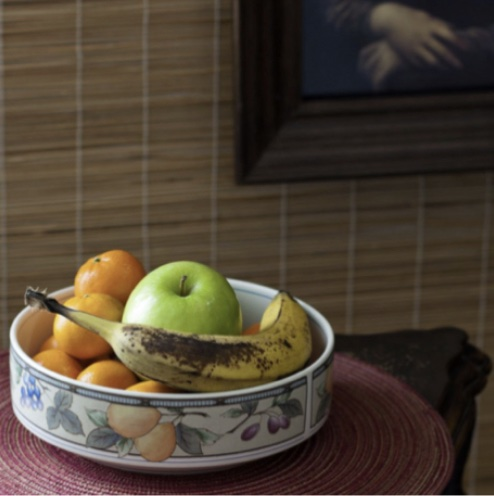

In [197]:
import torchvision.transforms as T

T.ToPILImage()(image)

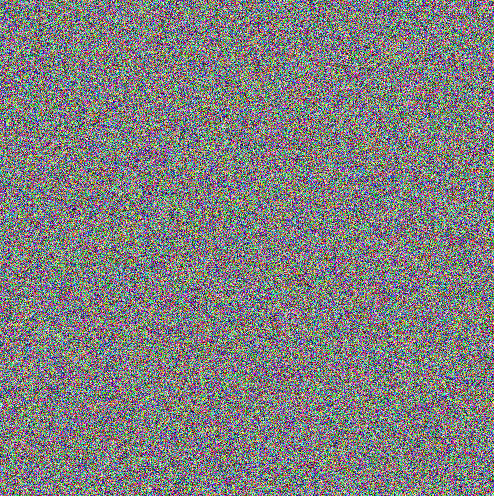

In [198]:
T.ToPILImage()(mask)

In [60]:
from diffusers import StableDiffusionPipeline, EulerDiscreteScheduler

pipeline = StableDiffusionPipeline.from_pretrained("CompVis/stable-diffusion-v1-4")
# pipeline.scheduler = EulerDiscreteScheduler.from_config(pipeline.scheduler.config)

Fetching 30 files:   0%|          | 0/30 [00:00<?, ?it/s]

The config attributes {'scaling_factor': 0.18215} were passed to AutoencoderKL, but are not expected and will be ignored. Please verify your config.json configuration file.
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["id2label"]` will be overriden.
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["bos_token_id"]` will be overriden.
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["eos_token_id"]` will be overriden.


In [55]:
image.shape

torch.Size([3, 496, 494])

In [10]:
# modify sample method of dpm_solver, most code are copied from https://github.com/LuChengTHU/dpm-solver/blob/main/dpm_solver_pytorch.py
# here we just record sample lantents and apply mask in sample process
def sample_edit(self, x, steps=20, t_start=None, t_end=None, order=3, skip_type='time_uniform',
                method='singlestep', lower_order_final=True, denoise_to_zero=False, solver_type='dpm_solver',
                atol=0.0078, rtol=0.05, record_list=None, mask=None
                ):
    t_0 = 1. / self.noise_schedule.total_N if t_end is None else t_end
    t_T = self.noise_schedule.T if t_start is None else t_start
    device = x.device
    if record_list is not None:
        assert len(record_list) == steps
    if method == 'adaptive':
        with torch.no_grad():
            x = self.dpm_solver_adaptive(x, order=order, t_T=t_T, t_0=t_0, atol=atol, rtol=rtol,
                                         solver_type=solver_type)
    elif method == 'multistep':
        assert steps >= order
        timesteps = self.get_time_steps(skip_type=skip_type, t_T=t_T, t_0=t_0, N=steps, device=device)
        assert timesteps.shape[0] - 1 == steps
        with torch.no_grad():
            vec_t = timesteps[0].expand((x.shape[0]))
            model_prev_list = [self.model_fn(x, vec_t)]
            t_prev_list = [vec_t]
            # Init the first `order` values by lower order multistep DPM-Solver.
            for init_order in range(1, order):
                vec_t = timesteps[init_order].expand(x.shape[0])
                x = self.multistep_dpm_solver_update(x, model_prev_list, t_prev_list, vec_t, init_order,
                                                     solver_type=solver_type)
                if mask is not None and record_list is not None:
                    x = record_list[init_order - 1].to(device) * (1. - mask) + x * mask
                model_prev_list.append(self.model_fn(x, vec_t))
                t_prev_list.append(vec_t)
            # Compute the remaining values by `order`-th order multistep DPM-Solver.
            for step in range(order, steps + 1):
                vec_t = timesteps[step].expand(x.shape[0])
                if lower_order_final and steps < 15:
                    step_order = min(order, steps + 1 - step)
                else:
                    step_order = order
                x = self.multistep_dpm_solver_update(x, model_prev_list, t_prev_list, vec_t, step_order,
                                                     solver_type=solver_type)
                if mask is not None and record_list is not None:
                    x = record_list[step - 1].to(device) * (1. - mask) + x * mask
                for i in range(order - 1):
                    t_prev_list[i] = t_prev_list[i + 1]
                    model_prev_list[i] = model_prev_list[i + 1]
                t_prev_list[-1] = vec_t
                # We do not need to evaluate the final model value.
                if step < steps:
                    model_prev_list[-1] = self.model_fn(x, vec_t)
    elif method in ['singlestep', 'singlestep_fixed']:
        if method == 'singlestep':
            timesteps_outer, orders = self.get_orders_and_timesteps_for_singlestep_solver(steps=steps, order=order,
                                                                                          skip_type=skip_type, t_T=t_T,
                                                                                          t_0=t_0, device=device)
        elif method == 'singlestep_fixed':
            K = steps // order
            orders = [order, ] * K
            timesteps_outer = self.get_time_steps(skip_type=skip_type, t_T=t_T, t_0=t_0, N=K, device=device)
        for i, order in enumerate(orders):
            t_T_inner, t_0_inner = timesteps_outer[i], timesteps_outer[i + 1]
            timesteps_inner = self.get_time_steps(skip_type=skip_type, t_T=t_T_inner.item(), t_0=t_0_inner.item(),
                                                  N=order, device=device)
            lambda_inner = self.noise_schedule.marginal_lambda(timesteps_inner)
            vec_s, vec_t = t_T_inner.tile(x.shape[0]), t_0_inner.tile(x.shape[0])
            h = lambda_inner[-1] - lambda_inner[0]
            r1 = None if order <= 1 else (lambda_inner[1] - lambda_inner[0]) / h
            r2 = None if order <= 2 else (lambda_inner[2] - lambda_inner[0]) / h
            x = self.singlestep_dpm_solver_update(x, vec_s, vec_t, order, solver_type=solver_type, r1=r1, r2=r2)
    if denoise_to_zero:
        x = self.denoise_to_zero_fn(x, torch.ones((x.shape[0],)).to(device) * t_0)
    return x


def sample(self, x, steps=20, t_start=None, t_end=None, order=3, skip_type='time_uniform',
           method='singlestep', lower_order_final=True, denoise_to_zero=False, solver_type='dpm_solver',
           atol=0.0078, rtol=0.05, record_process=False, record_list=None
           ):
    t_0 = 1. / self.noise_schedule.total_N if t_end is None else t_end
    t_T = self.noise_schedule.T if t_start is None else t_start
    device = x.device
    if method == 'adaptive':
        with torch.no_grad():
            x = self.dpm_solver_adaptive(x, order=order, t_T=t_T, t_0=t_0, atol=atol, rtol=rtol,
                                         solver_type=solver_type)
    elif method == 'multistep':
        assert steps >= order
        timesteps = self.get_time_steps(skip_type=skip_type, t_T=t_T, t_0=t_0, N=steps, device=device)
        assert timesteps.shape[0] - 1 == steps
        with torch.no_grad():
            vec_t = timesteps[0].expand((x.shape[0]))
            model_prev_list = [self.model_fn(x, vec_t)]
            t_prev_list = [vec_t]
            # Init the first `order` values by lower order multistep DPM-Solver.
            for init_order in range(1, order):
                vec_t = timesteps[init_order].expand(x.shape[0])
                x = self.multistep_dpm_solver_update(x, model_prev_list, t_prev_list, vec_t, init_order,
                                                     solver_type=solver_type)
                if record_process:
                    record_list.append(x.cpu())
                model_prev_list.append(self.model_fn(x, vec_t))
                t_prev_list.append(vec_t)
            # Compute the remaining values by `order`-th order multistep DPM-Solver.
            for step in range(order, steps + 1):
                vec_t = timesteps[step].expand(x.shape[0])
                if lower_order_final and steps < 15:
                    step_order = min(order, steps + 1 - step)
                else:
                    step_order = order
                x = self.multistep_dpm_solver_update(x, model_prev_list, t_prev_list, vec_t, step_order,
                                                     solver_type=solver_type)
                if record_process:
                    record_list.append(x.cpu())
                for i in range(order - 1):
                    t_prev_list[i] = t_prev_list[i + 1]
                    model_prev_list[i] = model_prev_list[i + 1]
                t_prev_list[-1] = vec_t
                # We do not need to evaluate the final model value.
                if step < steps:
                    model_prev_list[-1] = self.model_fn(x, vec_t)
    elif method in ['singlestep', 'singlestep_fixed']:
        if method == 'singlestep':
            timesteps_outer, orders = self.get_orders_and_timesteps_for_singlestep_solver(steps=steps, order=order,
                                                                                          skip_type=skip_type, t_T=t_T,
                                                                                          t_0=t_0, device=device)
        elif method == 'singlestep_fixed':
            K = steps // order
            orders = [order, ] * K
            timesteps_outer = self.get_time_steps(skip_type=skip_type, t_T=t_T, t_0=t_0, N=K, device=device)
        for i, order in enumerate(orders):
            t_T_inner, t_0_inner = timesteps_outer[i], timesteps_outer[i + 1]
            timesteps_inner = self.get_time_steps(skip_type=skip_type, t_T=t_T_inner.item(), t_0=t_0_inner.item(),
                                                  N=order, device=device)
            lambda_inner = self.noise_schedule.marginal_lambda(timesteps_inner)
            vec_s, vec_t = t_T_inner.tile(x.shape[0]), t_0_inner.tile(x.shape[0])
            h = lambda_inner[-1] - lambda_inner[0]
            r1 = None if order <= 1 else (lambda_inner[1] - lambda_inner[0]) / h
            r2 = None if order <= 2 else (lambda_inner[2] - lambda_inner[0]) / h
            x = self.singlestep_dpm_solver_update(x, vec_s, vec_t, order, solver_type=solver_type, r1=r1, r2=r2)
    if denoise_to_zero:
        x = self.denoise_to_zero_fn(x, torch.ones((x.shape[0],)).to(device) * t_0)
    return x

In [11]:
def diffedit(model, init_image,
             src_prompt: str = "A bowl of fruits",
             dst_prompt: str = "A bowl of pears",
             encode_ratio: float = 0.6,
             ddim_steps: int = 20,
             seed: int = 42,
             scale: float = 7.5,
             precision="autocast"):
    """
    :param init_image: image to be edit
    :param src_prompt: prompt describe origin image(i.e. A bowl of fruits)
    :param dst_prompt: prompt describe desired image(i.e. A bowl of pears)
    :param encode_ratio: how deep to encode origin image, must between 0-1
    :param ddim_steps: total ddim steps, actual encode steps = ddim_steps * encode ratio
    :param seed: random seed
    :param scale: classifier free guidance scale
    :param precision: ema precision
    """
    device = model.device

    model.cond_stage_model = model.cond_stage_model.to(device)
    precision_scope = autocast if precision == "autocast" else nullcontext
    assert os.path.isfile(opt.origin_image)
    init_image = load_img(opt.origin_image, opt).to(device)
    init_image = repeat(init_image, '1 ... -> b ...', b=1)

    with torch.no_grad():
        with precision_scope(device.type):
            with model.ema_scope():
                uc = None
                if scale != 1.0:
                    uc = model.get_learned_conditioning([""])
                src = model.get_learned_conditioning([src_prompt])
                dst = model.get_learned_conditioning([dst_prompt])
                init_latent = model.get_first_stage_encoding(model.encode_first_stage(init_image))

                # get mask
                mask = get_mask(model, src, dst, init_latent, 3, ddim_steps)
                plt.imshow(mask.detach().cpu().numpy())
                plt.show()
                
                ns = NoiseScheduleVP('discrete', betas=model.betas)
                model_fn = model_wrapper(
                    lambda x, t, c: model.apply_model(x, t, c),
                    ns,
                    model_type="noise",
                    guidance_type="classifier-free",
                    condition=src,
                    unconditional_condition=uc,
                    guidance_scale=scale
                )

                # add noise and record each step's output latent
                noiser = DPM_Solver(model_fn, ns, predict_x0=True, thresholding=False)
                noiser.sample = sample.__get__(noiser, type(noiser))
                record_list = []
                noised_sample = noiser.sample(
                    init_latent,
                    t_start=1. / model.num_timesteps,
                    t_end=encode_ratio,
                    method='multistep',
                    order=2,
                    steps=ddim_steps,
                    record_process=True,
                    record_list=record_list
                )

                # perform step wise edit
                model_fn_dst = model_wrapper(
                    lambda x, t, c: model.apply_model(x, t, c),
                    ns,
                    model_type="noise",
                    guidance_type="classifier-free",
                    condition=dst,
                    unconditional_condition=uc,
                    guidance_scale=scale
                )
                solver = DPM_Solver(model_fn_dst, ns, predict_x0=True, thresholding=False)

                solver.sample_edit = sample_edit.__get__(solver, type(solver))
                recover = solver.sample_edit(
                    noised_sample,
                    t_start=encode_ratio,
                    t_end=1. / model.num_timesteps,
                    method='multistep',
                    order=2,
                    steps=ddim_steps,
                    mask=mask,
                    record_list=list(reversed(record_list))
                )

                images = latent_to_image(model, recover)
                return images


In [16]:
seed = random.randrange(2 ** 32 - 1)
seed_everything(seed)

res = diffedit(pipeline, "data/fruit.png")

AttributeError: 'StableDiffusionPipeline' object has no attribute 'cond_stage_model'

In [18]:
pipeline.cond_stage_model

AttributeError: 'StableDiffusionPipeline' object has no attribute 'cond_stage_model'

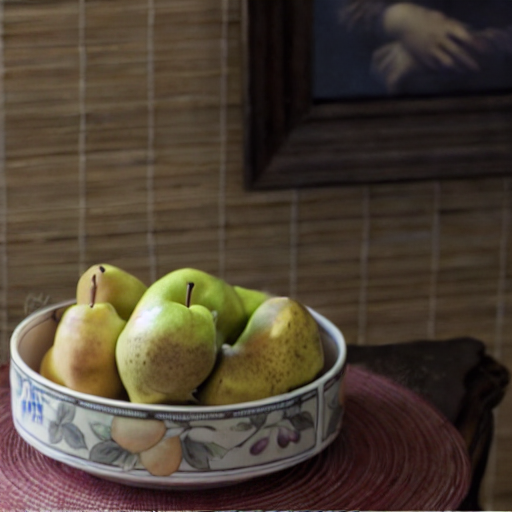

In [17]:
Image.fromarray(res[0])